### IMPORTATION

In [1]:
import pandas as pd 
import os 

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_palette("pastel")

### DEFINING FUNCTIONS

In [2]:
def extract_annotations(annotation_list, image_id):
    """
    Extract annotations from an image and return a list of dictionaries.
    If no annotations are found, return a single row with None values.
    
    Args:
        annotation_list: List of annotation dictionaries from Label Studio JSON export
        image_id: Identifier for the image being processed
    
    Returns:
        List of dictionaries, each containing bounding box information for one annotation.
        If no annotations exist, returns a single dictionary with None values.
    """
    rows = []
    
    # Iterate through all annotations for this image
    for annotation in annotation_list:
        for result in annotation['result']:
            # Only process rectangle labels (bounding boxes)
            if result['type'] == 'rectanglelabels':
                row = {
                    'image_id': image_id,
                    'bbox_id': result['id'],
                    'label': result['value']['rectanglelabels'][0],
                    'x': result['value']['x'],
                    'y': result['value']['y'],
                    'width': result['value']['width'],
                    'height': result['value']['height'],
                    'rotation': result['value']['rotation'],
                }
                rows.append(row)
    
    # If no annotations found, add a row with None values to keep track of unlabeled images
    if len(rows) == 0:
        rows.append({
            'image_id': image_id,
            'bbox_id': None,
            'label': None,
            'x': None,
            'y': None,
            'width': None,
            'height': None,
            'rotation': None,
        })
    
    return rows

### IMPORTATION AND FILTERING OF THE DATA

In [ ]:
# Load the labeled dataset from Label Studio JSON export
data = pd.read_json("Data/json_files/yolo_label_studio.json")

# Filter to keep only images with at least one annotation
data_labeled = data[data['total_annotations'] > 0].copy()
data_labeled = data_labeled[["annotations", "data"]]

# Extract image ID from the file path (remove extension and path)
data_labeled['image_id'] = data_labeled['data'].map(
    lambda x: os.path.splitext(os.path.basename(x['image']))[0]
)

data_labeled.head()

,annotations,data,image_id
0,"[{'id': 201, 'completed_by': 1, 'result': [{'o...",{'image': 'gs://yolo_nba_sponsor/train_images/...,-DYmMB-Z_Yk_frame_1
1,"[{'id': 202, 'completed_by': 1, 'result': [{'o...",{'image': 'gs://yolo_nba_sponsor/train_images/...,-DYmMB-Z_Yk_frame_2
2,"[{'id': 203, 'completed_by': 1, 'result': [{'o...",{'image': 'gs://yolo_nba_sponsor/train_images/...,-DYmMB-Z_Yk_frame_3
5,"[{'id': 206, 'completed_by': 1, 'result': [{'o...",{'image': 'gs://yolo_nba_sponsor/train_images/...,-YcElHorDfc_frame_1
7,"[{'id': 208, 'completed_by': 1, 'result': [{'o...",{'image': 'gs://yolo_nba_sponsor/train_images/...,-YcElHorDfc_frame_3


### EXTRACTING BOUNDING BOX INFORMATION FROM THE DATASET 

In [4]:
# Initialize list to store all bounding box rows
all_rows = []

# Iterate through each labeled image
for idx, row in data_labeled.iterrows():
    image_id = row['image_id']  
    annotations = row['annotations']
    
    # Extract all bounding boxes for this image
    extracted = extract_annotations(annotations, image_id)
    all_rows.extend(extracted)

# Create DataFrame with one row per bounding box
df_annotations = pd.DataFrame(all_rows)

df_annotations.head()

,image_id,bbox_id,label,x,y,width,height,rotation
0,-DYmMB-Z_Yk_frame_1,Js_9ECpzdK,basket-logo,66.217009,22.000652,5.219941,2.815249,0.0
1,-DYmMB-Z_Yk_frame_1,_rVdiAP7gx,basket-logo,72.375367,17.934235,6.686217,3.545088,0.0
2,-DYmMB-Z_Yk_frame_1,1uQ-1_t7Th,basket-logo,80.293255,39.726302,2.111437,5.421955,0.0
3,-DYmMB-Z_Yk_frame_1,QwwIy-OaAK,basket-logo,79.706745,47.129358,3.225806,4.587814,0.0
4,-DYmMB-Z_Yk_frame_1,1EaDL07aJ3,basket-logo,84.105572,49.214728,8.797654,6.137853,0.0


### EXPLORATORY DATA ANALYSIS

In [5]:
# ----------------------------------------------------------------------------
# Dataset Overview
# ----------------------------------------------------------------------------

print(f"\nNumber of unique images: {df_annotations['image_id'].nunique()}")
print(f"Number of different videos: {df_annotations['image_id'].map(lambda x: x[:x.find('frame_')]).nunique()}")
print(f"Number of images without labels: {df_annotations['label'].isna().sum()}")
print(f"\nTotal number of bounding boxes: {df_annotations['bbox_id'].nunique()}")


Number of unique images: 202
Number of different videos: 103
Number of images without labels: 41

Total number of bounding boxes: 840



Bounding boxes per class:
label
back-court-logo         85
basket-logo            299
mid-court-logo         173
side-court-led-logo    158
side-court-logo        125
Name: image_id, dtype: int64


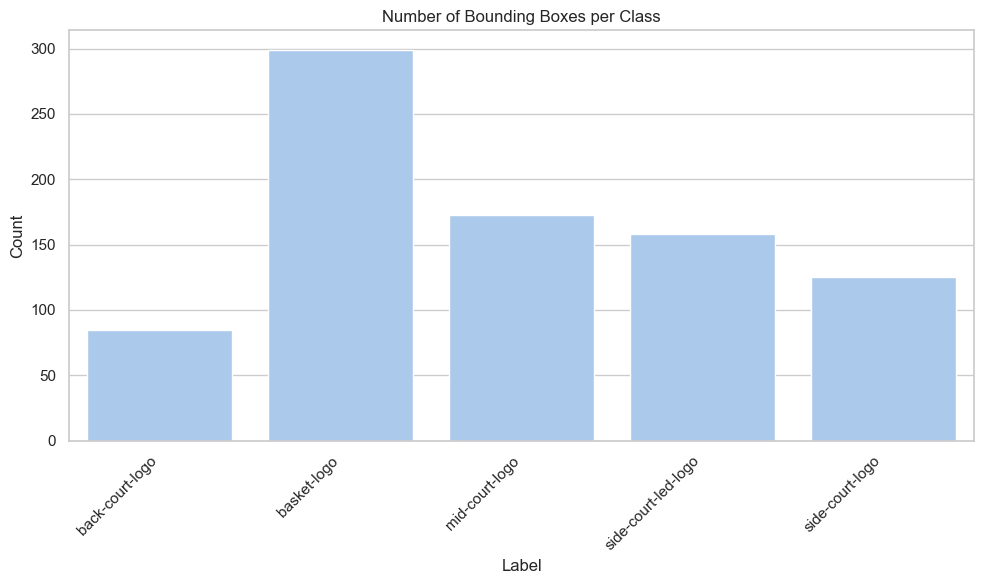

In [6]:
# ----------------------------------------------------------------------------
# Class Distribution
# ----------------------------------------------------------------------------

# Count bounding boxes per class
dist_labels = df_annotations.groupby("label")["image_id"].count()
print(f"\nBounding boxes per class:\n{dist_labels}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(y=dist_labels.values, x=dist_labels.index)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Number of Bounding Boxes per Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

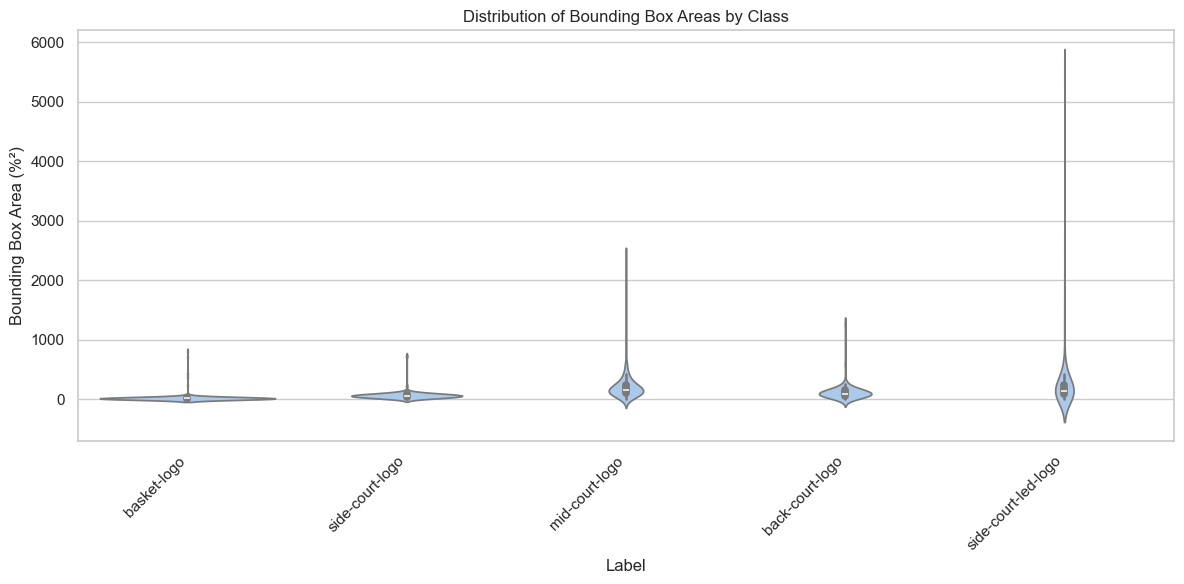

In [7]:
# ----------------------------------------------------------------------------
# Bounding Box Area Distribution
# ----------------------------------------------------------------------------

# Calculate bounding box area
df_annotations['area'] = df_annotations['width'] * df_annotations['height']

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_annotations, x='label', y='area')
plt.xlabel("Label")
plt.ylabel("Bounding Box Area (%²)")
plt.title("Distribution of Bounding Box Areas by Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

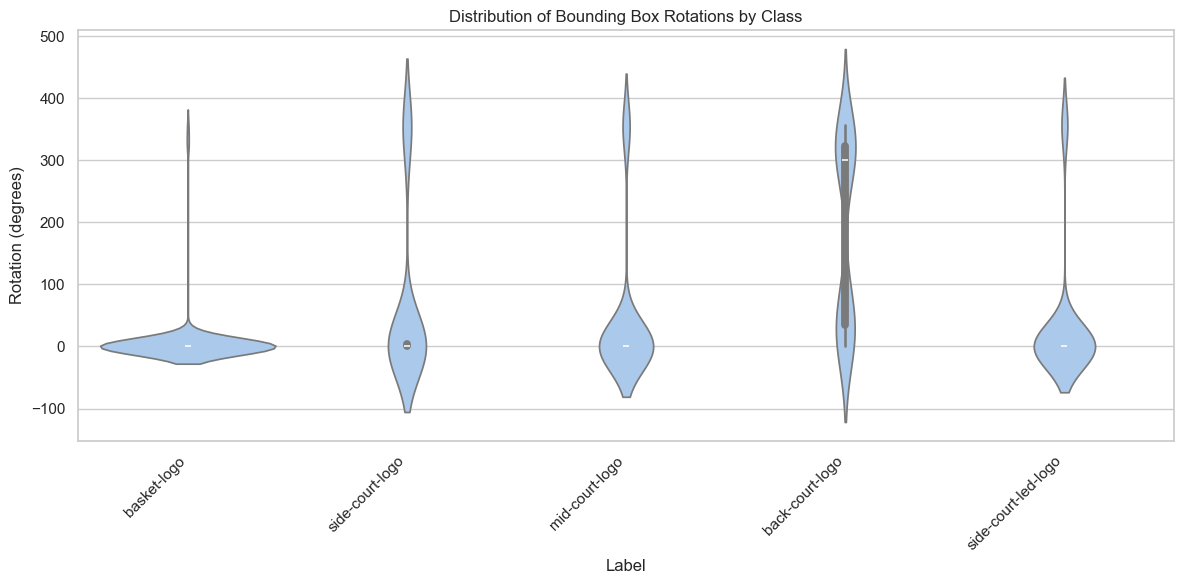

In [8]:
# ----------------------------------------------------------------------------
# Rotation Distribution
# ----------------------------------------------------------------------------

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_annotations, x='label', y='rotation')
plt.xlabel("Label")
plt.ylabel("Rotation (degrees)")
plt.title("Distribution of Bounding Box Rotations by Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

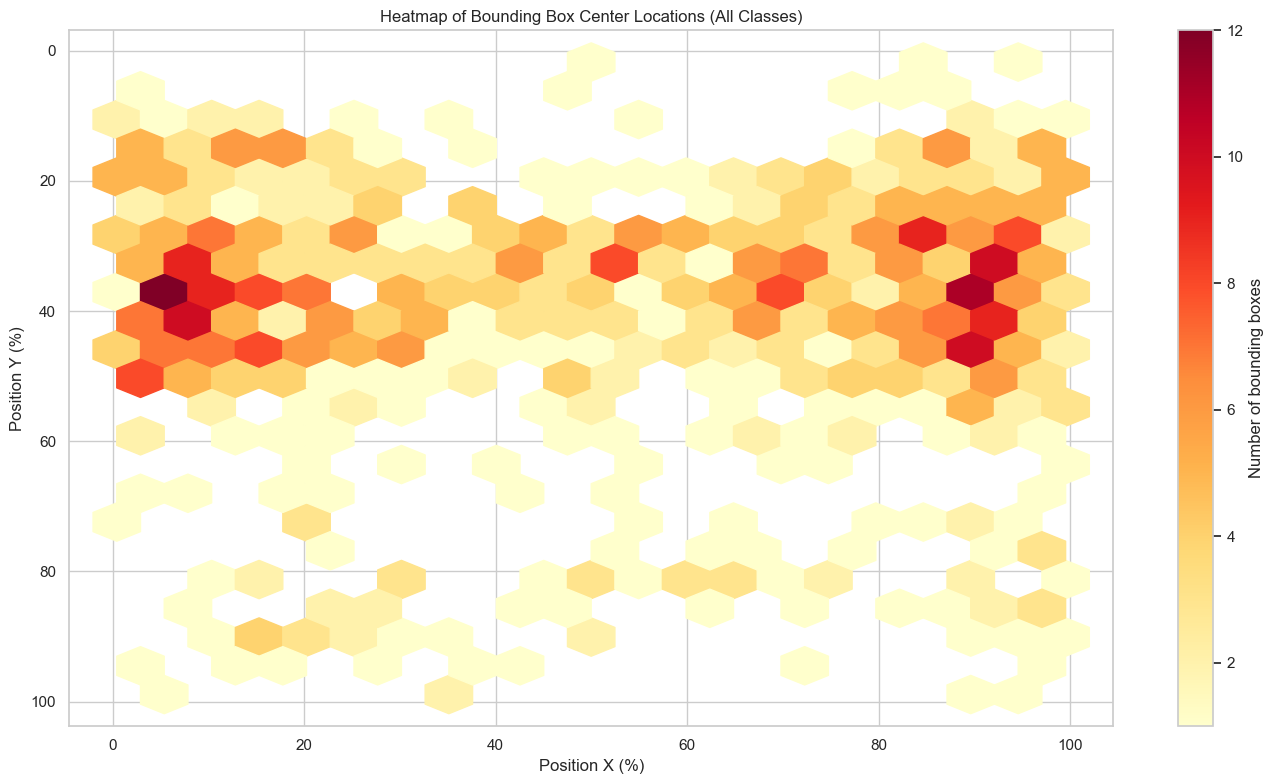

In [9]:
# ----------------------------------------------------------------------------
# Bounding Box Localization Heatmaps
# ----------------------------------------------------------------------------

# Calculate the center coordinates for each bounding box
df_annotations['center_x'] = df_annotations['x'] + df_annotations['width'] / 2
df_annotations['center_y'] = df_annotations['y'] + df_annotations['height'] / 2

# --- Heatmap for ALL classes combined ---
plt.figure(figsize=(14, 8))

# Use hexbin to create a 2D histogram of center points
plt.hexbin(df_annotations['center_x'], df_annotations['center_y'], 
           gridsize=20, cmap='YlOrRd', mincnt=1)
           
plt.colorbar(label='Number of bounding boxes')
plt.xlabel('Position X (%)')
plt.ylabel('Position Y (%)')
plt.title('Heatmap of Bounding Box Center Locations (All Classes)')

# Invert the Y-axis because image coordinates (0,0) are at the top-left
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

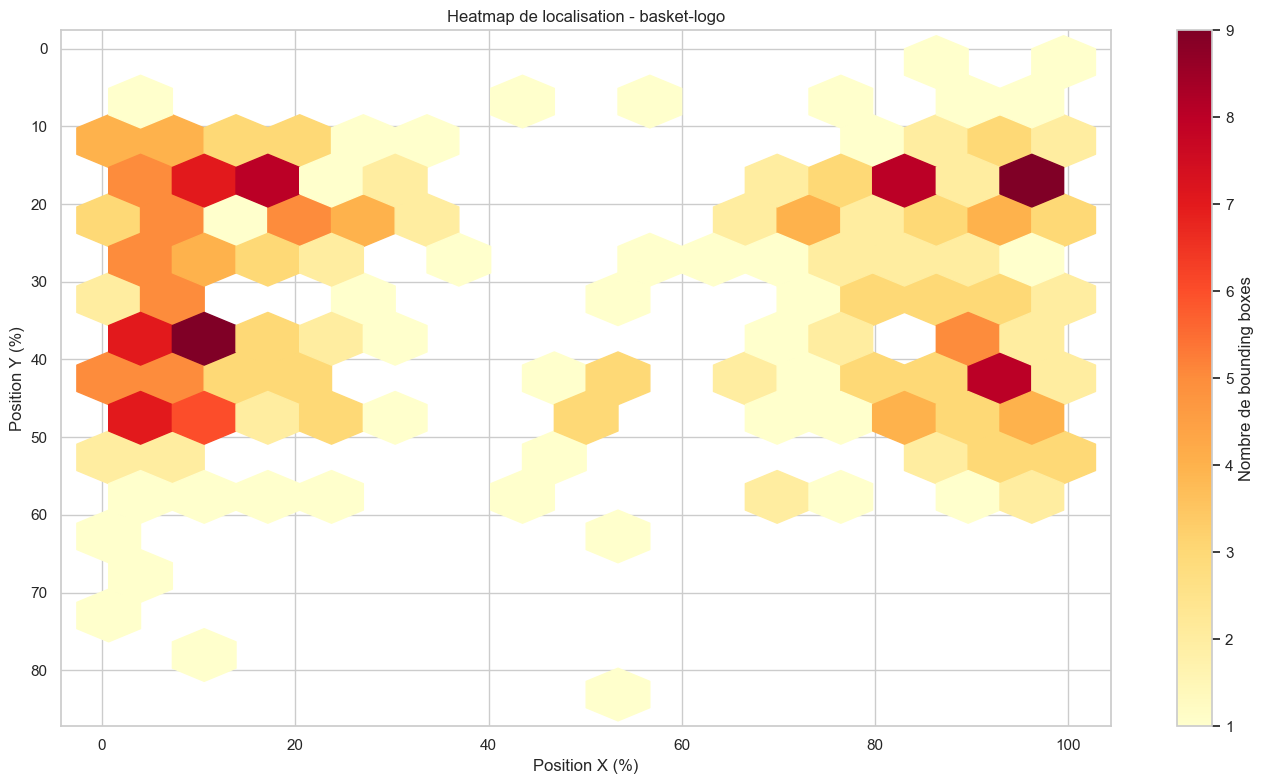

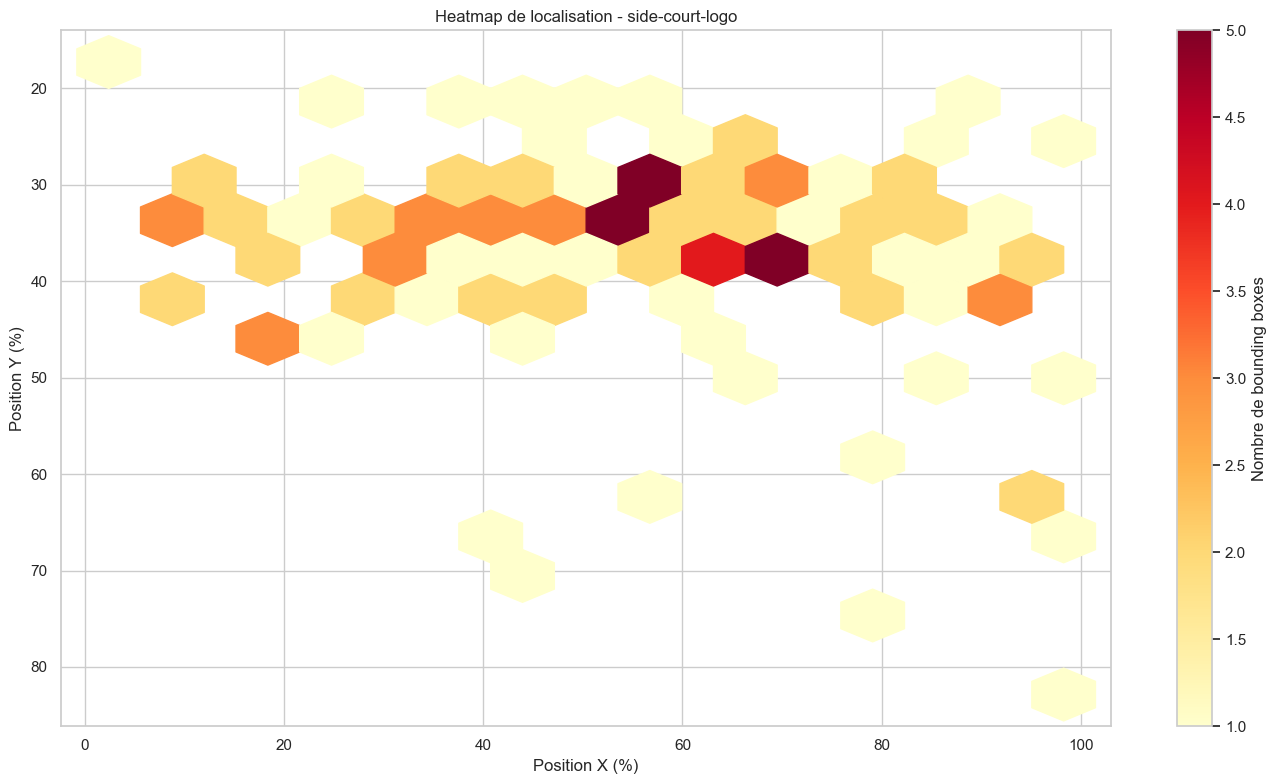

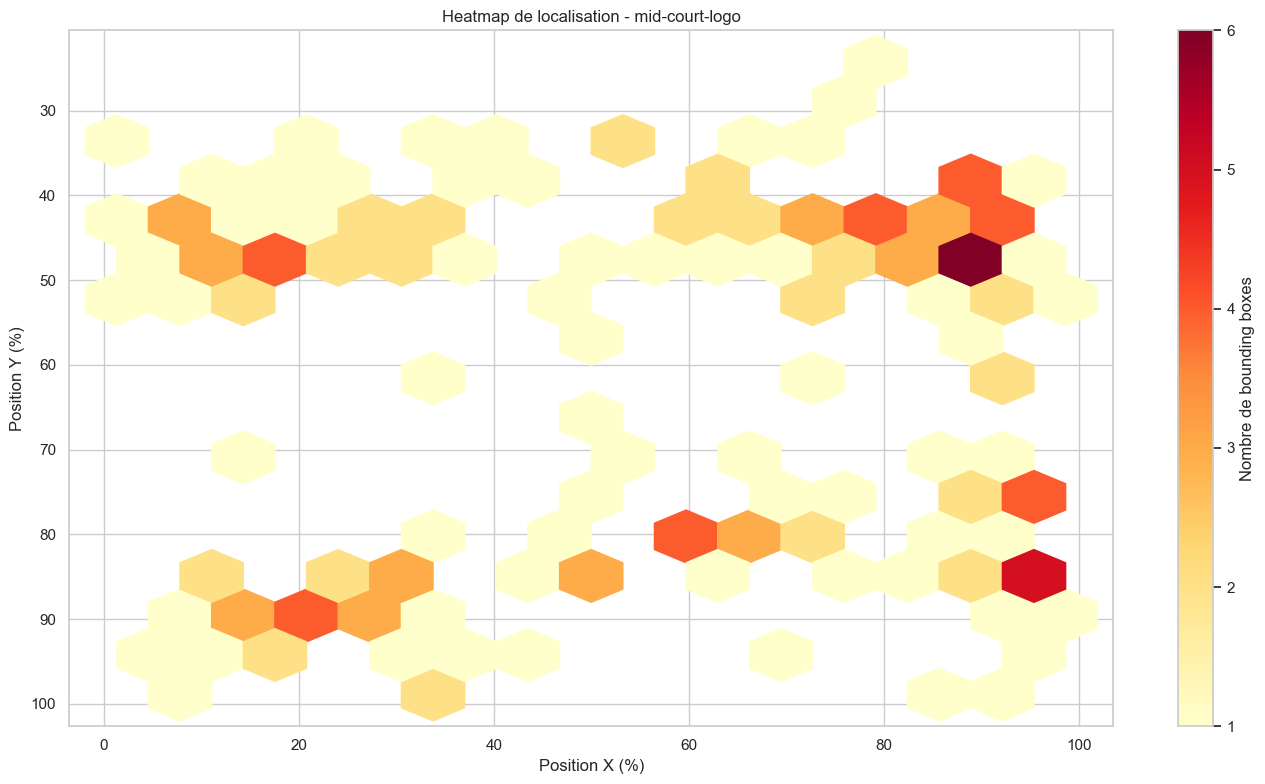

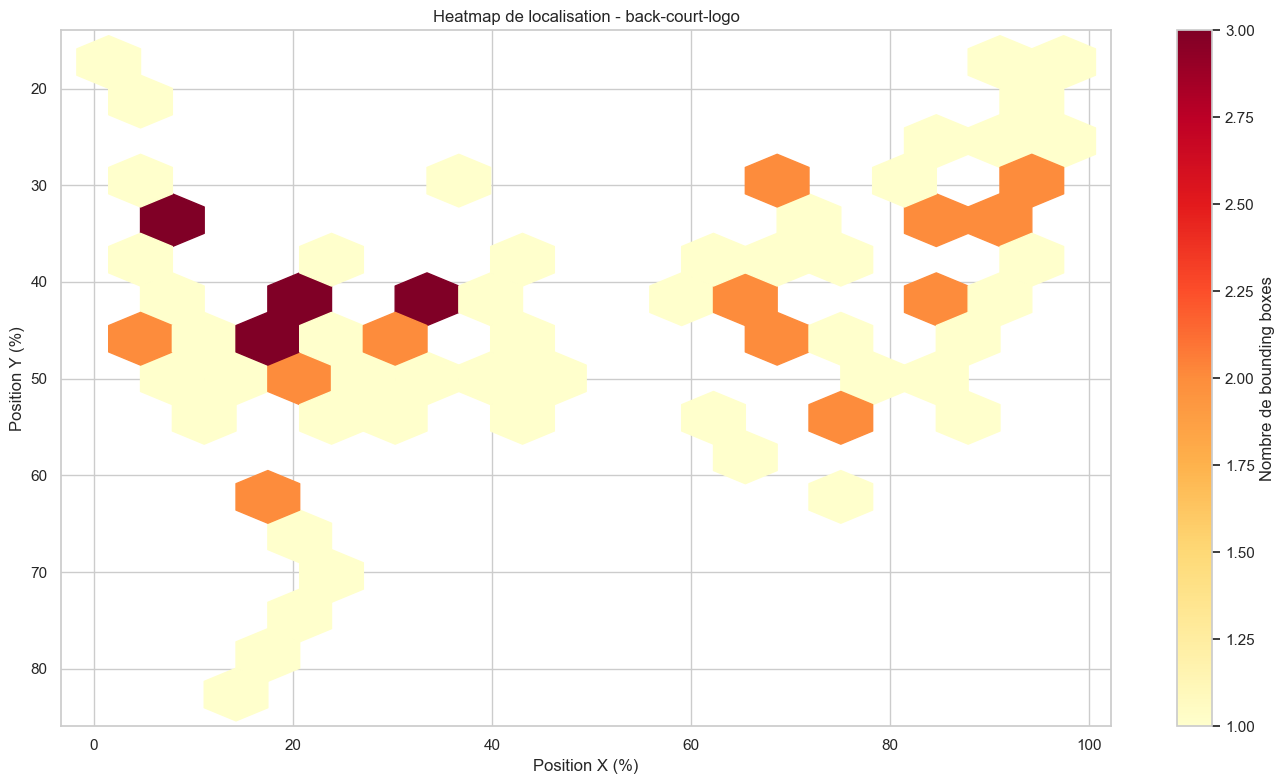

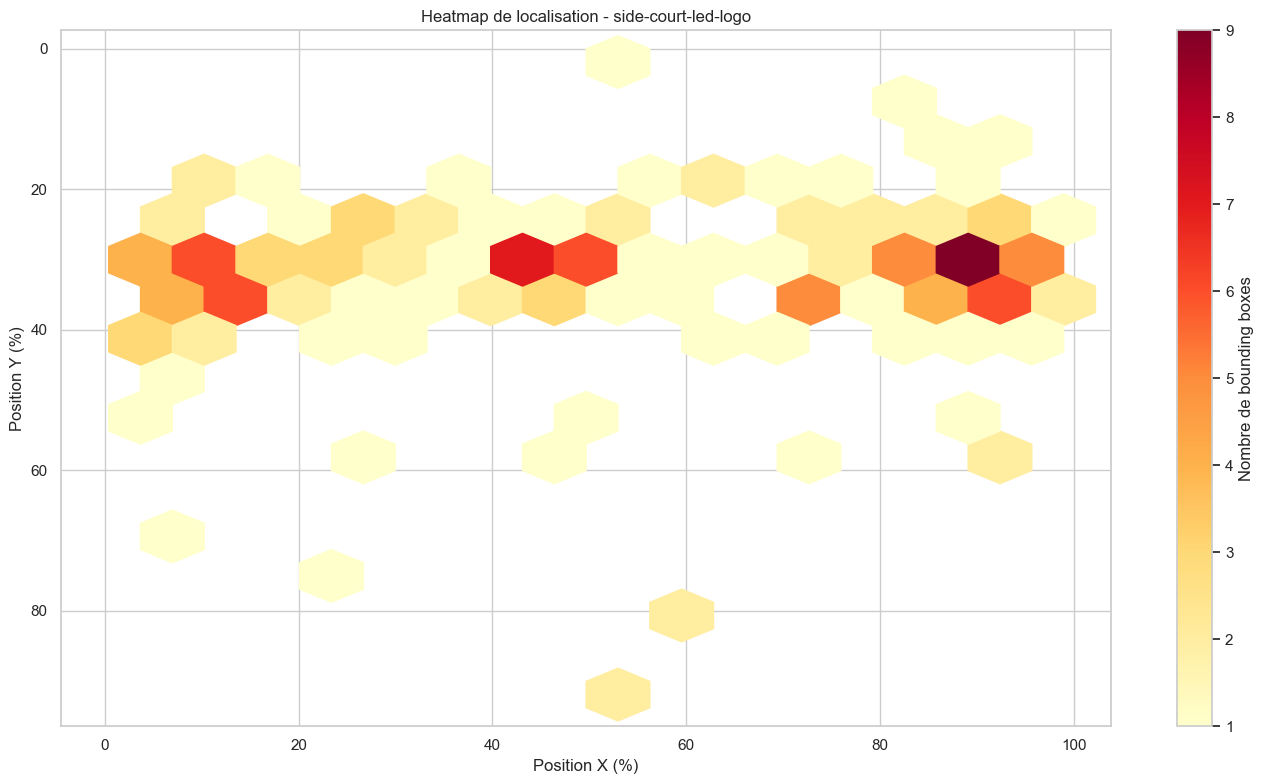

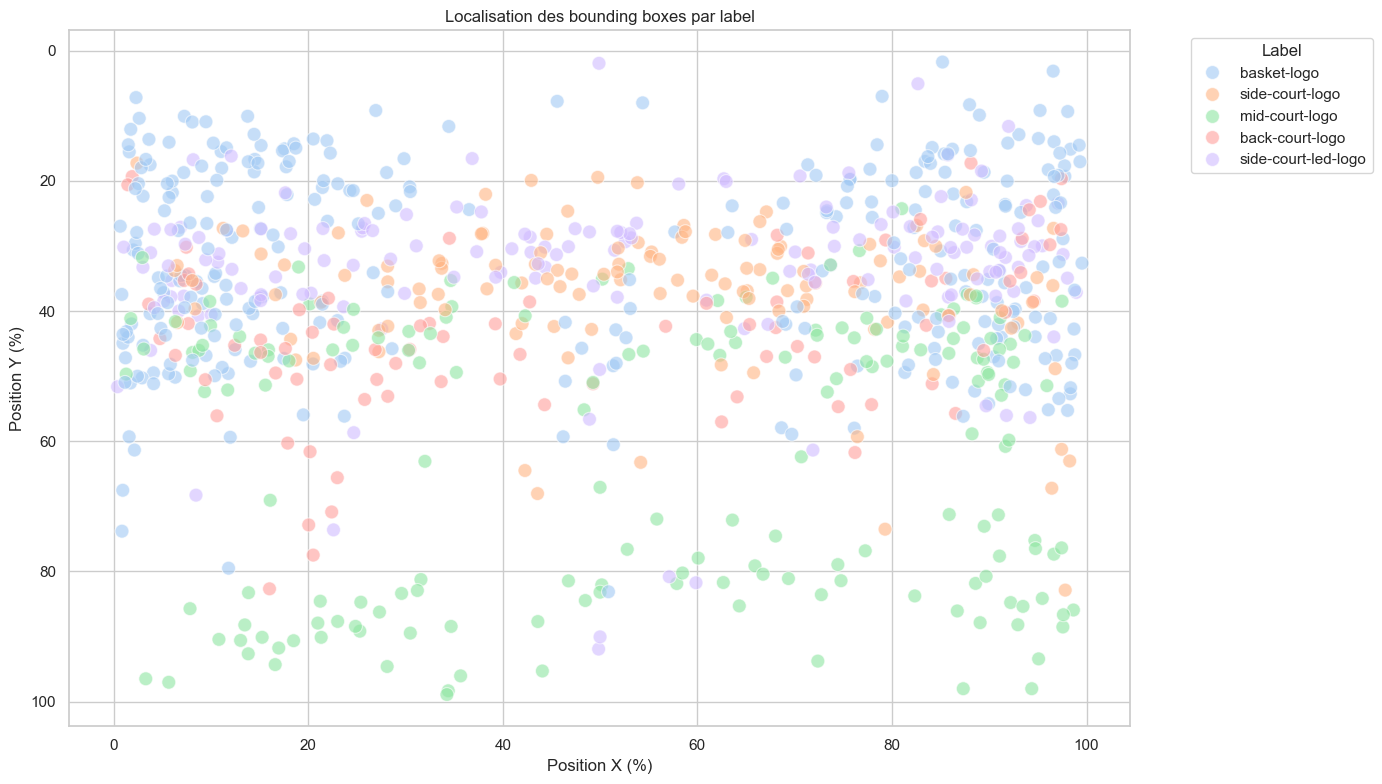

In [10]:
# ----------------------------------------------------------------------------
# Bounding Box Localization Heatmaps for each labels
# ----------------------------------------------------------------------------

for label in df_annotations['label'].unique()[:-1]:
    df_label = df_annotations[df_annotations['label'] == label]
    
    plt.figure(figsize=(14, 8))
    plt.hexbin(df_label['center_x'], df_label['center_y'], 
               gridsize=15, cmap='YlOrRd', mincnt=1)
    plt.colorbar(label='Nombre de bounding boxes')
    plt.title(f'Heatmap de localisation - {label}')
    plt.xlabel('Position X (%)')
    plt.ylabel('Position Y (%)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# All in one plot
plt.figure(figsize=(14, 8))

df_annotations['center_x'] = df_annotations['x'] + df_annotations['width'] / 2
df_annotations['center_y'] = df_annotations['y'] + df_annotations['height'] / 2

sns.scatterplot(data=df_annotations, x='center_x', y='center_y', 
                hue='label', s=100, alpha=0.6)

plt.xlabel('Position X (%)')
plt.ylabel('Position Y (%)')
plt.title('Localisation des bounding boxes par label')
plt.gca().invert_yaxis()
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
